In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from custom_metrics import f_beta_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold


In [10]:
df = pd.read_csv('cleaned_movies.csv')

Simple Resampling - Random Oversampling

In [11]:
from imblearn.over_sampling import RandomOverSampler

X = df.drop(columns=['genres', 'original_language', 'popularity_class']).copy()
y = df['popularity_class']

# should we add differt binding for oversampling?
# in this type of resampling we need numeric feature I added the mean value, but maybe for different algorithm juz adding nr index instead of fore example genres will be better?

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)


In [12]:
df_resampled = pd.concat([X_resampled.reset_index(drop=True), 
                          pd.Series(y_resampled, name='popularity_class')], axis=1)


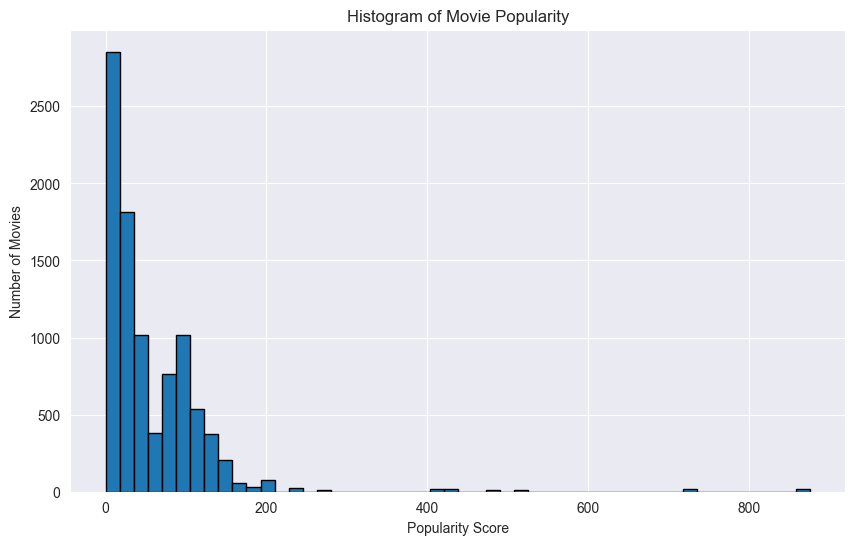

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_resampled['popularity'], bins=50, edgecolor='black')
plt.title('Histogram of Movie Popularity')
plt.xlabel('Popularity Score')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.savefig('histogram_popularity_simply_resampling_full.png')
plt.show()

In [14]:
X = df_resampled.drop(columns=['popularity']).copy()
y = df_resampled['popularity']

print(X.dtypes)

budget                int64
runtime             float64
vote_average        float64
vote_count            int64
revenue               int64
release_year          int64
genres_score        float64
language_score      float64
popularity_class      int64
dtype: object


SVR

In [15]:
from sklearn.svm import SVR

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])
    
# 5-fold cross-validation (for R^2 score)
scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')

print("R² score for each fold:", scores)
print("Mean R² score:", scores.mean())

# we have to adjust metrics

R² score for each fold: [ 0.53471635  0.69683798  0.06850185  0.30912212 -0.13697223]
Mean R² score: 0.29444121324625594


In [16]:
# SVR with other metrics - MAE and RMSE
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = []
rmse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # MAE
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

print("\nMean Absolute Error (per fold):", mae_scores)
print("Mean MAE:", np.mean(mae_scores))

print("\nRoot Mean Squared Error (per fold):", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))


Mean Absolute Error (per fold): [15.077634044775074, 12.35719859222911, 14.632946722621675, 17.168833841552544, 12.814042877750099]
Mean MAE: 14.4101312157857

Root Mean Squared Error (per fold): [np.float64(58.397616380070346), np.float64(40.042157375538544), np.float64(59.96183453319935), np.float64(66.10875568834007), np.float64(42.78199359577698)]
Mean RMSE: 53.458471514585064


In [17]:
# SVR with custom metric - F1 score for regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

f1_reg_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    f1_reg = f_beta_regression(y_test.values, y_pred, beta=1.0, threshold=10)
    f1_reg_scores.append(f1_reg)

print("F1 adapted for regression per fold:", f1_reg_scores)
print("Mean F1 adapted for regression:", np.mean(f1_reg_scores))

F1 adapted for regression per fold: [np.float64(0.44788972157563817), np.float64(0.5099627318735896), np.float64(0.49957688396063105), np.float64(0.43939920620701467), np.float64(0.4993574393888082)]
Mean F1 adapted for regression: 0.47923719660113634


KNN

In [18]:
from sklearn.neighbors import KNeighborsRegressor

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
print("R² score for each fold:", scores)
print("Mean R² score:", scores.mean())
# we have to adjust metrics

R² score for each fold: [0.95642735 0.85879385 0.88217299 0.9948251  0.98116524]
Mean R² score: 0.9346769070833154


In [19]:
# KNN with other metrics - MAE and RMSE
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = []
rmse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)


print("\nMean Absolute Error (per fold):", mae_scores)
print("Mean MAE:", np.mean(mae_scores))

print("\nRoot Mean Squared Error (per fold):", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))


Mean Absolute Error (per fold): [3.293519258887089, 3.4096538452728264, 3.272075393949217, 3.303708327714749, 3.1305558165316048]
Mean MAE: 3.2819025284710976

Root Mean Squared Error (per fold): [np.float64(6.0603120490743), np.float64(5.665479904147226), np.float64(6.569890824654554), np.float64(5.774435439638923), np.float64(5.3123280977816325)]
Mean RMSE: 5.876489263059327


In [20]:
# KNN with custom metric - F1 score for regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

f1_reg_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    f1_reg = f_beta_regression(y_test.values, y_pred, beta=1.0, threshold=10)
    f1_reg_scores.append(f1_reg)

print("\nF1 adapted for regression (per fold):", f1_reg_scores)
print("Mean F1 adapted for regression:", np.mean(f1_reg_scores))


F1 adapted for regression (per fold): [np.float64(0.9427283829635011), np.float64(0.9308329960561864), np.float64(0.9510342260550916), np.float64(0.9434429117932543), np.float64(0.9503640873621011)]
Mean F1 adapted for regression: 0.9436805208460269


DECISION TREE

In [21]:
from sklearn.tree import DecisionTreeRegressor

pipeline = Pipeline([
    ('tree', DecisionTreeRegressor(random_state=42))
])

r2_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
print("R² score per fold:", r2_scores)
print("Mean R² score:", np.mean(r2_scores))


R² score per fold: [0.98257248 0.93401854 0.98100562 1.         1.        ]
Mean R² score: 0.9795193282307982


In [22]:
# Decision Tree with other metrics - MAE and RMSE
pipeline = Pipeline([
    ('tree', DecisionTreeRegressor(random_state=42))
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = []
rmse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

print("\nMean Absolute Error (per fold):", mae_scores)
print("Mean MAE:", np.mean(mae_scores))

print("\nRoot Mean Squared Error (per fold):", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))


Mean Absolute Error (per fold): [1.6110113522420386, 1.4522117547271807, 1.470895240950845, 1.462672854403034, 1.440568466234475]
Mean MAE: 1.4874719337115145

Root Mean Squared Error (per fold): [np.float64(4.2056159678370095), np.float64(3.6297358725184337), np.float64(3.9852765097530267), np.float64(3.807232911309099), np.float64(3.459617807902081)]
Mean RMSE: 3.8174958138639297


In [23]:
# Decision Tree with custom metric - F1 score for regression
pipeline = Pipeline([
    ('tree', DecisionTreeRegressor(random_state=42))
])

f1_reg_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    f1_reg = f_beta_regression(y_test.values, y_pred, beta=1.0, threshold=10)
    f1_reg_scores.append(f1_reg)

print("\nF1 adapted for regression (per fold):", f1_reg_scores)
print("Mean F1 adapted for regression:", np.mean(f1_reg_scores))


F1 adapted for regression (per fold): [np.float64(0.9739804381206484), np.float64(0.9770344683152296), np.float64(0.9788908813354875), np.float64(0.9757832333180552), np.float64(0.9816241569916906)]
Mean F1 adapted for regression: 0.9774626356162223


MULTILAYER PERCEPTRON (MLP)

In [24]:
from sklearn.neural_network import MLPRegressor

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, early_stopping=True, random_state=42))
])

r2_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
print("R² score per fold:", r2_scores)
print("Mean R² score:", np.mean(r2_scores))

R² score per fold: [0.93436654 0.76640022 0.84344832 0.99199195 0.99360536]
Mean R² score: 0.9059624805656817


In [25]:
# MLP with other metrics - MAE and RMSE
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, early_stopping=True, random_state=42))
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = []
rmse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

print("\nMean Absolute Error (per fold):", mae_scores)
print("Mean MAE:", np.mean(mae_scores))

print("\nRoot Mean Squared Error (per fold):", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))



Mean Absolute Error (per fold): [4.211836916386989, 4.541283683527086, 4.2313117596241065, 4.203907553428462, 4.583608227576914]
Mean MAE: 4.354389628108711

Root Mean Squared Error (per fold): [np.float64(9.262466922815218), np.float64(7.431883326654031), np.float64(7.668076471252019), np.float64(6.442277938681833), np.float64(9.185652361906063)]
Mean RMSE: 7.998071404261833


In [26]:
# MLP with custom metric - F1 score for regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, early_stopping=True, random_state=42))
])

f1_reg_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    f1_reg = f_beta_regression(y_test.values, y_pred, beta=1.0, threshold=10)
    f1_reg_scores.append(f1_reg)

print("\nF1 adapted for regression (per fold):", f1_reg_scores)
print("Mean F1 adapted for regression:", np.mean(f1_reg_scores))


F1 adapted for regression (per fold): [np.float64(0.9192153544987184), np.float64(0.8715620724122217), np.float64(0.9070565488630834), np.float64(0.9099053069078484), np.float64(0.8969946133933434)]
Mean F1 adapted for regression: 0.9009467792150432
